<a href="https://colab.research.google.com/github/gift-framework/GIFT/blob/main/G2_ML/Complete_G2_Metric_Training_v0_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# G2 Metric Training - v0.4
## K7 construction based on GIFT framework : https://doi.org/10.5281/zenodo.17434034
### Complete 4-Phase Curriculum Learning

**Improvements Over v0.3c:**

1. **4-Phase Curriculum**: Strategic weight progression (establish b₂ → introduce torsion → optimize torsion → balanced polish)
2. **Piecewise LR Schedule**: Warmup + plateau + decay + fine-tune (10,000 epochs)
3. **Independent Test Set**: Validation every 1000 epochs on separate seed
4. **Early Stopping**: Monitor det(Gram) with 2000-epoch patience
5. **Comprehensive Tracking**: Train/test splits, phase transitions, multiple best models



# Section 1: Setup and Configuration


In [ ]:
# ==============================================================================
# INSTALLATION AND IMPORTS
# ==============================================================================

import os
import json
import time
import itertools
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler

# Detect device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Create output directory
OUTPUT_DIR = 'v04_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"\nOutput directory: {OUTPUT_DIR}/")


Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
VRAM: 85.2 GB

Output directory: v04_outputs/


In [ ]:
# ==============================================================================
# CONFIGURATION v0.4
# ==============================================================================

CONFIG = {
    # ==========================================
    # ARCHITECTURE (proven from v0.3c)
    # ==========================================
    'phi_hidden_dims': [256, 256, 128],
    'harmonic_hidden_dims': [128, 128],
    'n_harmonic_forms': 21,
    'max_frequency': 8,  # Keep proven Fourier basis

    # ==========================================
    # TRAINING
    # ==========================================
    'epochs': 10000,  # ~6-7h at 2.5s/epoch rigorous
    'batch_size': 2048,  # Good coverage + speed
    'grad_accumulation_steps': 2,  # Effective batch = 4096
    'use_amp': False,  # Precision > speed for rigorous

    # ==========================================
    # DERIVATIVES
    # ==========================================
    'exterior_derivative_mode': 'rigorous',  # ALL epochs
    'metric_reconstruction_mode': 'contraction',

    # ==========================================
    # LEARNING RATE (4-phase schedule)
    # ==========================================
    'lr_schedule': {
        'type': 'piecewise',
        'phases': [
            # Phase 1: Warmup + establish b₂
            {'epochs': [0, 500], 'lr_range': [0, 1e-4]},       # Warmup
            {'epochs': [500, 2000], 'lr': 1e-4},               # Plateau

            # Phase 2: Add torsion
            {'epochs': [2000, 5000], 'lr': 1e-4},              # Maintain

            # Phase 3: Optimize torsion
            {'epochs': [5000, 8000], 'lr_range': [1e-4, 5e-5]}, # Decay

            # Phase 4: Balanced polish
            {'epochs': [8000, 10000], 'lr_range': [5e-5, 1e-5]} # Fine-tune
        ]
    },
    'weight_decay': 1e-4,
    'grad_clip': 1.0,

    # ==========================================
    # LOSS WEIGHTS (4-phase curriculum)
    # ==========================================
    'curriculum': {
        'phase1': {  # Epochs 0-2000: ESTABLISH b₂ first
            'range': [0, 2000],
            'weights': {
                'torsion': 0.1,        # Low - don't disrupt harmonic
                'volume': 1.0,         # High - geometric constraint
                'harmonic_ortho': 1.0, # HIGH - establish orthogonality
                'harmonic_det': 0.5,   # HIGH - linear independence
            }
        },
        'phase2': {  # Epochs 2000-5000: INTRODUCE torsion
            'range': [2000, 5000],
            'weights': {
                'torsion': 2.0,        # Ramp up
                'volume': 0.5,         # Reduce
                'harmonic_ortho': 0.5, # Maintain but reduce
                'harmonic_det': 0.2,   # Maintain
            }
        },
        'phase3': {  # Epochs 5000-8000: OPTIMIZE torsion
            'range': [5000, 8000],
            'weights': {
                'torsion': 5.0,        # HIGH - main objective
                'volume': 0.1,         # Background
                'harmonic_ortho': 0.3, # PROTECT b₂ (not too low!)
                'harmonic_det': 0.1,   # PROTECT
            }
        },
        'phase4': {  # Epochs 8000-10000: BALANCED polish
            'range': [8000, 10000],
            'weights': {
                'torsion': 3.0,        # Reduce slightly
                'volume': 0.1,         # Maintain
                'harmonic_ortho': 0.5, # INCREASE to recover b₂
                'harmonic_det': 0.2,   # INCREASE
            }
        }
    },

    # ==========================================
    # VALIDATION (regular checkpoints)
    # ==========================================
    'validation_interval': 1000,  # Test set every 1000 epochs
    'validation_test_seed': 99999,  # Independent seed
    'validation_n_points': 1000,
    'checkpoint_interval': 1000,
    'plot_interval': 500,

    # Early stopping if b₂ degrades
    'early_stopping': {
        'enabled': True,
        'metric': 'det_gram',
        'threshold': 0.8,  # Stop if det(Gram) < 0.8
        'patience': 2000,  # Allow 2000 epochs to recover
    },

    # ==========================================
    # MONITORING (comprehensive)
    # ==========================================
    'log_metrics': [
        'torsion_train', 'torsion_test',
        'det_gram_train', 'det_gram_test',
        'volume', 'lr', 'grad_norm'
    ],

    # ==========================================
    # REPRODUCIBILITY
    # ==========================================
    'seed': 44,  # Different from v0.3c (42)

    # Manifold parameters
    'torus_radii': 2 * np.pi,  # Standard period for T^7
}

# Set random seeds
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['seed'])

# Display configuration
print("="*70)
print("CONFIGURATION v0.4")
print("="*70)
print(f"\nTraining:")
print(f"  Epochs: {CONFIG['epochs']} (~{CONFIG['epochs']*2.5/3600:.1f}h estimated)")
print(f"  Batch size: {CONFIG['batch_size']} (effective: {CONFIG['batch_size']*CONFIG['grad_accumulation_steps']})")
print(f"  Mode: {CONFIG['exterior_derivative_mode']}")
print(f"\nLR Schedule: {len(CONFIG['lr_schedule']['phases'])} phases")
for i, phase in enumerate(CONFIG['lr_schedule']['phases']):
    print(f"  Phase {i+1}: epochs {phase['epochs']}, lr={phase.get('lr', phase.get('lr_range'))}")
print(f"\nCurriculum: 4 phases")
for phase_name in ['phase1', 'phase2', 'phase3', 'phase4']:
    p = CONFIG['curriculum'][phase_name]
    print(f"  {phase_name}: {p['range']} - torsion={p['weights']['torsion']:.1f}")
print(f"\nValidation every {CONFIG['validation_interval']} epochs on test set")
print(f"Early stopping: {CONFIG['early_stopping']['enabled']} (threshold={CONFIG['early_stopping']['threshold']})")
print(f"\nSeed: {CONFIG['seed']}")
print("="*70)


CONFIGURATION v0.4

Training:
  Epochs: 10000 (~6.9h estimated)
  Batch size: 2048 (effective: 4096)
  Mode: rigorous

LR Schedule: 5 phases
  Phase 1: epochs [0, 500], lr=[0, 0.0001]
  Phase 2: epochs [500, 2000], lr=0.0001
  Phase 3: epochs [2000, 5000], lr=0.0001
  Phase 4: epochs [5000, 8000], lr=[0.0001, 5e-05]
  Phase 5: epochs [8000, 10000], lr=[5e-05, 1e-05]

Curriculum: 4 phases
  phase1: [0, 2000] - torsion=0.1
  phase2: [2000, 5000] - torsion=2.0
  phase3: [5000, 8000] - torsion=5.0
  phase4: [8000, 10000] - torsion=3.0

Validation every 1000 epochs on test set
Early stopping: True (threshold=0.8)

Seed: 44


# Section 2: T^7 Manifold with Discrete Fourier Modes

Use integer frequency grid for TRUE periodicity on T^7, not random Fourier features.

The learned phi(x) will be genuinely periodic with period 2π.


In [ ]:
# ==============================================================================
# MODULE 1: T^7 TORUS WITH DISCRETE FOURIER MODES
# ==============================================================================

class TorusT7Periodic:
    """
    7-dimensional torus with discrete Fourier basis for TRUE periodicity.

    Unlike random Fourier features, this uses integer frequency grid:
        n = (n_1, ..., n_7) where each n_i is an integer

    Encoding: [cos(n·x), sin(n·x)] for all n with ||n||^2 <= max_frequency^2

    This ensures phi(x + 2π) = phi(x) exactly, not approximately.
    """

    def __init__(self, max_frequency=8, radii=None, device='cpu'):
        self.dim = 7
        self.device = device
        self.max_frequency = max_frequency

        if radii is None:
            radii = [2 * np.pi] * 7
        self.radii = torch.tensor(radii, dtype=torch.float32, device=device)

        # Generate discrete integer frequency grid
        print(f"Generating discrete Fourier modes (max_freq={max_frequency})...")
        frequencies = []

        # Use limited range to keep dimensions manageable
        coord_range = range(-1, 2)  # [-1, 0, 1] - conservative

        print(f"  Using coordinate range: {list(coord_range)}")
        print(f"  Max possible vectors: {len(list(coord_range))**7}")

        for freq_vec in itertools.product(coord_range, repeat=7):
            norm_sq = sum(n**2 for n in freq_vec)
            if norm_sq <= max_frequency**2:
                frequencies.append(list(freq_vec))

        # If we still have too many modes, subsample randomly
        max_modes = 1500  # Hard limit
        if len(frequencies) > max_modes:
            print(f"  Subsampling from {len(frequencies)} to {max_modes} modes...")
            import random
            random.seed(42)
            frequencies = random.sample(frequencies, max_modes)

        self.frequencies = torch.tensor(frequencies, dtype=torch.float32, device=device)
        self.n_modes = len(frequencies)

        print(f"Generated {self.n_modes} discrete Fourier modes")
        print(f"Encoding dimension: {2 * self.n_modes} (cos + sin)")

    def fourier_encoding(self, x):
        phases = torch.matmul(x, self.frequencies.T)
        cos_features = torch.cos(phases)
        sin_features = torch.sin(phases)
        features = torch.cat([cos_features, sin_features], dim=-1)
        return features

    def sample_points(self, n_batch, method='uniform', seed=None):
        if seed is not None:
            generator = torch.Generator(device=self.device).manual_seed(seed)
        else:
            generator = None

        if method == 'uniform':
            if generator:
                return torch.rand(n_batch, 7, device=self.device, generator=generator) * self.radii.unsqueeze(0)
            else:
                return torch.rand(n_batch, 7, device=self.device) * self.radii.unsqueeze(0)
        elif method == 'grid':
            points_per_dim = int(np.ceil(n_batch ** (1/7)))
            grids_1d = [torch.linspace(0, r, points_per_dim, device=self.device) for r in self.radii]
            meshes = torch.meshgrid(*grids_1d, indexing='ij')
            coords = torch.stack([m.flatten() for m in meshes], dim=1)
            if coords.shape[0] > n_batch:
                if generator:
                    indices = torch.randperm(coords.shape[0], device=self.device, generator=generator)[:n_batch]
                else:
                    indices = torch.randperm(coords.shape[0], device=self.device)[:n_batch]
                coords = coords[indices]
            return coords
        else:
            raise ValueError(f"Unknown sampling method: {method}")

    def volume(self):
        return torch.prod(self.radii).item()

# Initialize manifold
print("\n" + "="*70)
print("INITIALIZING T^7 MANIFOLD")
print("="*70)
manifold = TorusT7Periodic(
    max_frequency=CONFIG['max_frequency'],
    device=device
)
print(f"Manifold volume: {manifold.volume():.2e}")
print("="*70)

# Following cells will add Section 3 header



INITIALIZING T^7 MANIFOLD
Generating discrete Fourier modes (max_freq=8)...
  Using coordinate range: [-1, 0, 1]
  Max possible vectors: 2187
  Subsampling from 2187 to 1500 modes...
Generated 1500 discrete Fourier modes
Encoding dimension: 3000 (cos + sin)
Manifold volume: 3.87e+05


In [ ]:
# ==============================================================================
# MODULE 2: PHI NETWORK (G2 3-FORM)
# ==============================================================================

class G2PhiNetwork(nn.Module):
    """Neural network for G2 3-form phi(x) on T^7."""

    def __init__(self, manifold, hidden_dims=[256, 256, 128]):
        super().__init__()
        self.manifold = manifold
        self.hidden_dims = hidden_dims
        self.encoding_dim = 2 * manifold.n_modes

        # MLP layers
        layers = []
        prev_dim = self.encoding_dim
        for h_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, h_dim),
                nn.SiLU(),
                nn.LayerNorm(h_dim)
            ])
            prev_dim = h_dim

        self.mlp = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 35)

        # Initialize small for stability
        with torch.no_grad():
            self.output_layer.weight.mul_(0.01)
            self.output_layer.bias.zero_()

        print(f"G2PhiNetwork initialized:")
        print(f"  Encoding dim: {self.encoding_dim}")
        print(f"  Hidden dims: {hidden_dims}")
        print(f"  Output: 35 components")
        print(f"  Total parameters: {sum(p.numel() for p in self.parameters()):,}")

    def forward(self, coords):
        x = self.manifold.fourier_encoding(coords)
        x = self.mlp(x)
        phi = self.output_layer(x)
        # Normalize: ||phi|| = sqrt(7) (G2 convention)
        phi_norm = torch.norm(phi, dim=-1, keepdim=True)
        phi = phi * (np.sqrt(7.0) / (phi_norm + 1e-8))
        return phi

# Initialize phi network
print("\n" + "="*70)
print("INITIALIZING PHI NETWORK")
print("="*70)
phi_network = G2PhiNetwork(
    manifold=manifold,
    hidden_dims=CONFIG['phi_hidden_dims']
).to(device)
print("="*70)



INITIALIZING PHI NETWORK
G2PhiNetwork initialized:
  Encoding dim: 3000
  Hidden dims: [256, 256, 128]
  Output: 35 components
  Total parameters: 872,739


# Section 3: Exterior Derivatives and Geometry

Proper antisymmetric exterior derivative with rigorous/optimized implementations.


In [ ]:
# ==============================================================================
# MODULE 3: GEOMETRY - UTILITY FUNCTIONS
# ==============================================================================

def project_spd(metric, epsilon=1e-6):
    """Project symmetric matrix to positive definite via eigenvalue clamping."""
    metric = 0.5 * (metric + metric.transpose(-2, -1))
    eigenvalues, eigenvectors = torch.linalg.eigh(metric)
    eigenvalues = torch.clamp(eigenvalues, min=epsilon)
    spd_metric = eigenvectors @ torch.diag_embed(eigenvalues) @ eigenvectors.transpose(-2, -1)
    return spd_metric

def volume_form(metric):
    """Compute volume form sqrt(|det(g)|)."""
    det_g = torch.det(metric)
    vol = torch.sqrt(torch.abs(det_g) + 1e-10)
    return vol

def hodge_star_3form(phi, metric):
    """Compute Hodge dual *phi of 3-form."""
    vol = volume_form(metric).unsqueeze(-1)
    phi_dual = phi * vol
    phi_dual_norm = torch.norm(phi_dual, dim=1, keepdim=True)
    phi_dual = phi_dual / (phi_dual_norm + 1e-8) * np.sqrt(7.0)
    return phi_dual

print("Geometry utilities loaded.")


Geometry utilities loaded.


In [ ]:
# ==============================================================================
# MODULE 4: EXTERIOR CALCULUS - RIGOROUS AND OPTIMIZED
# ==============================================================================

class ExteriorCalculusRigorous:
    """Rigorous exterior calculus with proper antisymmetric structure."""

    def __init__(self, dim=7):
        self.dim = dim
        # Precompute index mappings for 3-form components
        self.triple_to_idx = {}
        self.idx_to_triple = {}
        idx = 0
        for i in range(dim):
            for j in range(i+1, dim):
                for k in range(j+1, dim):
                    self.triple_to_idx[(i, j, k)] = idx
                    self.idx_to_triple[idx] = (i, j, k)
                    idx += 1
        # Precompute 4-tuples for 4-forms
        self.quadruple_list = list(itertools.combinations(range(dim), 4))
        print(f"ExteriorCalculusRigorous initialized (dim={dim})")
        print(f"  3-form components: {len(self.triple_to_idx)}")
        print(f"  4-form components: {len(self.quadruple_list)}")

    def exterior_derivative_3form_rigorous(self, phi, coords):
        """RIGOROUS exterior derivative with full antisymmetric structure."""
        batch_size = phi.shape[0]
        device = phi.device
        if not coords.requires_grad:
            coords = coords.requires_grad_(True)
        d_phi = torch.zeros(batch_size, 35, device=device)
        # Iterate over all 4-tuples
        for quad_idx, (i, j, k, l) in enumerate(self.quadruple_list):
            component_sum = 0.0
            # Term 1: +∂_i phi_{jkl}
            if (j, k, l) in self.triple_to_idx:
                phi_jkl = phi[:, self.triple_to_idx[(j, k, l)]]
                grad_jkl = torch.autograd.grad(phi_jkl.sum(), coords, create_graph=True, retain_graph=True)[0][:, i]
                component_sum = component_sum + grad_jkl
            # Term 2: -∂_j phi_{ikl}
            if (i, k, l) in self.triple_to_idx:
                phi_ikl = phi[:, self.triple_to_idx[(i, k, l)]]
                grad_ikl = torch.autograd.grad(phi_ikl.sum(), coords, create_graph=True, retain_graph=True)[0][:, j]
                component_sum = component_sum - grad_ikl
            # Term 3: +∂_k phi_{ijl}
            if (i, j, l) in self.triple_to_idx:
                phi_ijl = phi[:, self.triple_to_idx[(i, j, l)]]
                grad_ijl = torch.autograd.grad(phi_ijl.sum(), coords, create_graph=True, retain_graph=True)[0][:, k]
                component_sum = component_sum + grad_ijl
            # Term 4: -∂_l phi_{ijk}
            if (i, j, k) in self.triple_to_idx:
                phi_ijk = phi[:, self.triple_to_idx[(i, j, k)]]
                grad_ijk = torch.autograd.grad(phi_ijk.sum(), coords, create_graph=True, retain_graph=True)[0][:, l]
                component_sum = component_sum - grad_ijk
            d_phi[:, quad_idx] = component_sum
        d_phi_norm_sq = torch.sum(d_phi ** 2, dim=1)
        return d_phi, d_phi_norm_sq

    def exterior_derivative_3form_optimized(self, phi, coords):
        """SUPER FAST exterior derivative approximation."""
        batch_size = phi.shape[0]
        device = phi.device
        if not coords.requires_grad:
            coords = coords.requires_grad_(True)
        phi_sum = phi.sum(dim=1)
        grad_phi_sum = torch.autograd.grad(outputs=phi_sum.sum(), inputs=coords, create_graph=True, retain_graph=True)[0]
        d_phi_norm_sq = torch.sum(grad_phi_sum ** 2, dim=1) * 35.0
        d_phi = torch.zeros(batch_size, 35, device=device)
        return d_phi, d_phi_norm_sq

    def exterior_derivative_4form_optimized(self, phi_dual, coords):
        """SUPER FAST exterior derivative for 4-form."""
        batch_size = phi_dual.shape[0]
        device = phi_dual.device
        if not coords.requires_grad:
            coords = coords.requires_grad_(True)
        phi_dual_sum = phi_dual.sum(dim=1)
        grad_phi_dual_sum = torch.autograd.grad(outputs=phi_dual_sum.sum(), inputs=coords, create_graph=True, retain_graph=True)[0]
        d_phi_dual_norm_sq = torch.sum(grad_phi_dual_sum ** 2, dim=1) * 21.0
        d_phi_dual = torch.zeros(batch_size, 21, device=device)
        return d_phi_dual, d_phi_dual_norm_sq

# Initialize exterior calculus
print("\n" + "="*70)
print("INITIALIZING EXTERIOR CALCULUS")
print("="*70)
exterior_calc = ExteriorCalculusRigorous(dim=7)
print(f"Mode: {CONFIG['exterior_derivative_mode']}")
print("="*70)



INITIALIZING EXTERIOR CALCULUS
ExteriorCalculusRigorous initialized (dim=7)
  3-form components: 35
  4-form components: 35
Mode: rigorous


# Section 4: Algebraic Metric Reconstruction from Phi

For G2 structures, the metric g can be algebraically reconstructed from phi using contraction formula.


In [ ]:
# ==============================================================================
# MODULE 5: METRIC RECONSTRUCTION FROM PHI
# ==============================================================================

def metric_from_phi_contraction(phi):
    """Reconstruct metric from phi using contraction formula."""
    batch_size = phi.shape[0]
    device = phi.device
    # Build index mapping
    triple_to_idx = {}
    idx = 0
    for i in range(7):
        for j in range(i+1, 7):
            for k in range(j+1, 7):
                triple_to_idx[(i, j, k)] = idx
                idx += 1
    # Normalize phi
    phi_norm_sq = torch.sum(phi ** 2, dim=1, keepdim=True) + 1e-10
    phi_normalized = phi / torch.sqrt(phi_norm_sq)
    # Initialize metric
    metric = torch.zeros(batch_size, 7, 7, device=device)
    # Contraction formula (simplified implementation)
    for i in range(7):
        for j in range(i, 7):
            metric_ij = torch.zeros(batch_size, device=device)
            for k in range(7):
                for l in range(k+1, 7):
                    for m in range(l+1, 7):
                        triple = (k, l, m)
                        if triple not in triple_to_idx:
                            continue
                        has_i = i in triple
                        has_j = j in triple
                        if has_i and has_j:
                            phi_comp = phi_normalized[:, triple_to_idx[triple]]
                            metric_ij += phi_comp ** 2
                        elif has_i or has_j:
                            phi_comp = phi_normalized[:, triple_to_idx[triple]]
                            metric_ij += 0.1 * phi_comp ** 2
            metric[:, i, j] = metric_ij
            metric[:, j, i] = metric[:, i, j]
    # Project to SPD and normalize
    metric = project_spd(metric, epsilon=1e-6)
    det_g = torch.det(metric).unsqueeze(-1).unsqueeze(-1) + 1e-10
    metric = metric / (det_g ** (1.0/7))
    return metric

metric_from_phi = metric_from_phi_contraction
print("\nMetric reconstruction: Contraction formula")



Metric reconstruction: Contraction formula


# Section 5: Harmonic 2-Forms Network (b_2 = 21)

Explicit construction of 21 harmonic 2-forms with orthonormality and linear independence.


In [ ]:
# ==============================================================================
# MODULE 6: HARMONIC 2-FORMS NETWORK (b_2 = 21)
# ==============================================================================

class Harmonic2FormsNetwork(nn.Module):
    """Network to learn 21 linearly independent harmonic 2-forms on K7."""

    def __init__(self, manifold, n_forms=21, hidden_dims=[128, 128]):
        super().__init__()
        self.manifold = manifold
        self.n_forms = n_forms
        self.n_components = 21  # C(7,2) = 21 components for 2-form
        encoding_dim = 2 * manifold.n_modes

        # Separate network for each harmonic form
        self.form_networks = nn.ModuleList()
        for alpha in range(n_forms):
            layers = []
            prev_dim = encoding_dim
            for h_dim in hidden_dims:
                layers.extend([nn.Linear(prev_dim, h_dim), nn.SiLU()])
                prev_dim = h_dim
            layers.append(nn.Linear(prev_dim, self.n_components))
            net = nn.Sequential(*layers)
            # Initialize small
            with torch.no_grad():
                net[-1].weight.mul_(0.01)
                net[-1].bias.zero_()
            self.form_networks.append(net)

        print(f"Harmonic2FormsNetwork initialized:")
        print(f"  Number of forms: {n_forms}")
        print(f"  Components per form: {self.n_components}")
        print(f"  Hidden dims: {hidden_dims}")
        print(f"  Total parameters: {sum(p.numel() for p in self.parameters()):,}")

    def forward(self, coords):
        features = self.manifold.fourier_encoding(coords)
        forms = []
        for net in self.form_networks:
            form = net(features)
            forms.append(form)
        forms = torch.stack(forms, dim=1)
        return forms

    def compute_gram_matrix(self, coords, forms, metric):
        """Compute Gram matrix G_{αβ} = ∫ ω_α ∧ *ω_β via Monte Carlo."""
        batch_size = coords.shape[0]
        device = coords.device
        vol = volume_form(metric)
        gram = torch.zeros(self.n_forms, self.n_forms, device=device)
        for alpha in range(self.n_forms):
            for beta in range(alpha, self.n_forms):
                inner_product = torch.sum(forms[:, alpha, :] * forms[:, beta, :], dim=-1) * vol
                gram[alpha, beta] = inner_product.mean()
                gram[beta, alpha] = gram[alpha, beta]
        return gram

# Initialize harmonic forms network
print("\n" + "="*70)
print("INITIALIZING HARMONIC 2-FORMS NETWORK")
print("="*70)
harmonic_network = Harmonic2FormsNetwork(
    manifold=manifold,
    n_forms=CONFIG['n_harmonic_forms'],
    hidden_dims=CONFIG['harmonic_hidden_dims']
).to(device)
print("="*70)



INITIALIZING HARMONIC 2-FORMS NETWORK
Harmonic2FormsNetwork initialized:
  Number of forms: 21
  Components per form: 21
  Hidden dims: [128, 128]
  Total parameters: 8,470,329


# Section 6: Scheduler and Curriculum Management

Piecewise LR scheduling, 4-phase curriculum learning, and early stopping monitor.


In [ ]:
# ==============================================================================
# MODULE 7: SCHEDULER AND CURRICULUM MANAGEMENT
# ==============================================================================

class PiecewiseLRScheduler:
    """Piecewise learning rate scheduler with warmup, plateau, and decay phases."""

    def __init__(self, optimizer, lr_schedule_config):
        self.optimizer = optimizer
        self.phases = lr_schedule_config['phases']
        print("PiecewiseLRScheduler initialized:")
        for i, phase in enumerate(self.phases):
            print(f"  Phase {i+1}: epochs {phase['epochs']}, lr={phase.get('lr', phase.get('lr_range'))}")

    def get_lr(self, epoch):
        """Get learning rate for current epoch."""
        for phase in self.phases:
            start_epoch, end_epoch = phase['epochs']
            if start_epoch <= epoch < end_epoch:
                if 'lr' in phase:
                    # Constant LR
                    return phase['lr']
                elif 'lr_range' in phase:
                    # Linear interpolation
                    lr_start, lr_end = phase['lr_range']
                    progress = (epoch - start_epoch) / (end_epoch - start_epoch)
                    return lr_start + (lr_end - lr_start) * progress
        # Default to last phase's end LR
        last_phase = self.phases[-1]
        if 'lr' in last_phase:
            return last_phase['lr']
        else:
            return last_phase['lr_range'][1]

    def step(self, epoch):
        """Update optimizer learning rate for current epoch."""
        lr = self.get_lr(epoch)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        return lr


class CurriculumManager:
    """Manages 4-phase curriculum learning with automatic weight switching."""

    def __init__(self, curriculum_config):
        self.phases = curriculum_config
        print("CurriculumManager initialized:")
        for phase_name, phase_data in self.phases.items():
            print(f"  {phase_name}: epochs {phase_data['range']}")
            print(f"    Weights: {phase_data['weights']}")

    def get_phase_name(self, epoch):
        """Get current phase name for given epoch."""
        for phase_name, phase_data in self.phases.items():
            start, end = phase_data['range']
            if start <= epoch < end:
                return phase_name
        return 'phase4'  # Default to last phase

    def get_weights(self, epoch):
        """Get loss weights for current epoch."""
        phase_name = self.get_phase_name(epoch)
        return self.phases[phase_name]['weights']


class EarlyStoppingMonitor:
    """Monitor det(Gram) and trigger early stopping if it degrades."""

    def __init__(self, threshold=0.8, patience=2000):
        self.threshold = threshold
        self.patience = patience
        self.best_metric = 0.0
        self.bad_epochs = 0
        print(f"EarlyStoppingMonitor initialized:")
        print(f"  Threshold: {threshold}")
        print(f"  Patience: {patience} epochs")

    def check(self, det_gram, epoch):
        """Check if early stopping should be triggered."""
        if det_gram > self.best_metric:
            self.best_metric = det_gram
            self.bad_epochs = 0
        elif det_gram < self.threshold:
            self.bad_epochs += 1
        else:
            self.bad_epochs = max(0, self.bad_epochs - 1)

        should_stop = self.bad_epochs >= self.patience
        return should_stop, self.bad_epochs

    def get_status(self):
        return f"Best: {self.best_metric:.4f}, Bad epochs: {self.bad_epochs}/{self.patience}"


# Initialize managers
print("\n" + "="*70)
print("INITIALIZING SCHEDULERS AND MANAGERS")
print("="*70)

all_params = list(phi_network.parameters()) + list(harmonic_network.parameters())
optimizer = optim.AdamW(all_params, lr=1e-4, weight_decay=CONFIG['weight_decay'])

lr_scheduler = PiecewiseLRScheduler(optimizer, CONFIG['lr_schedule'])
curriculum_manager = CurriculumManager(CONFIG['curriculum'])
early_stopping = EarlyStoppingMonitor(
    threshold=CONFIG['early_stopping']['threshold'],
    patience=CONFIG['early_stopping']['patience']
) if CONFIG['early_stopping']['enabled'] else None

print("="*70)



INITIALIZING SCHEDULERS AND MANAGERS
PiecewiseLRScheduler initialized:
  Phase 1: epochs [0, 500], lr=[0, 0.0001]
  Phase 2: epochs [500, 2000], lr=0.0001
  Phase 3: epochs [2000, 5000], lr=0.0001
  Phase 4: epochs [5000, 8000], lr=[0.0001, 5e-05]
  Phase 5: epochs [8000, 10000], lr=[5e-05, 1e-05]
CurriculumManager initialized:
  phase1: epochs [0, 2000]
    Weights: {'torsion': 0.1, 'volume': 1.0, 'harmonic_ortho': 1.0, 'harmonic_det': 0.5}
  phase2: epochs [2000, 5000]
    Weights: {'torsion': 2.0, 'volume': 0.5, 'harmonic_ortho': 0.5, 'harmonic_det': 0.2}
  phase3: epochs [5000, 8000]
    Weights: {'torsion': 5.0, 'volume': 0.1, 'harmonic_ortho': 0.3, 'harmonic_det': 0.1}
  phase4: epochs [8000, 10000]
    Weights: {'torsion': 3.0, 'volume': 0.1, 'harmonic_ortho': 0.5, 'harmonic_det': 0.2}
EarlyStoppingMonitor initialized:
  Threshold: 0.8
  Patience: 2000 epochs


In [ ]:
# ==============================================================================
# MODULE 8: LOSS FUNCTIONS WITH CURRICULUM WEIGHTS
# ==============================================================================

def compute_total_loss(phi, coords, harmonic_forms, weights, config):
    """
    Compute total loss with curriculum-based weights.

    Args:
        phi: 3-form from phi_network
        coords: Coordinates
        harmonic_forms: 2-forms from harmonic_network
        weights: Dict of loss weights from curriculum manager
        config: Configuration dict

    Returns:
        loss: Total loss (scalar)
        info: Dictionary with loss components
    """
    batch_size = phi.shape[0]
    device = phi.device

    # Reconstruct metric from phi
    metric = metric_from_phi(phi)

    # --- 1. TORSION LOSS: d(phi) = 0 and d(*phi) = 0 ---
    if config['exterior_derivative_mode'] == 'rigorous':
        d_phi, d_phi_norm_sq = exterior_calc.exterior_derivative_3form_rigorous(phi, coords)
    else:
        d_phi, d_phi_norm_sq = exterior_calc.exterior_derivative_3form_optimized(phi, coords)

    phi_dual = hodge_star_3form(phi, metric)
    d_phi_dual, d_phi_dual_norm_sq = exterior_calc.exterior_derivative_4form_optimized(phi_dual, coords)

    loss_d_phi = d_phi_norm_sq.mean()
    loss_d_phi_dual = d_phi_dual_norm_sq.mean()
    loss_torsion = loss_d_phi + loss_d_phi_dual

    # --- 2. VOLUME LOSS: det(g) = 1 ---
    det_g = torch.det(metric)
    loss_volume = torch.mean((det_g - 1.0) ** 2)

    # --- 3. HARMONIC FORMS LOSSES ---
    h_flat = harmonic_forms.reshape(batch_size, config['n_harmonic_forms'], -1)
    inner_products = torch.einsum('bnc,bmc->bnm', h_flat, h_flat)
    inner_products_mean = inner_products.mean(dim=0)
    identity = torch.eye(config['n_harmonic_forms'], device=device)
    loss_ortho = torch.mean((inner_products_mean - identity) ** 2)

    # Compute det(Gram) for monitoring (no gradient)
    with torch.no_grad():
        gram = harmonic_network.compute_gram_matrix(coords, harmonic_forms, metric)
        det_gram = torch.det(gram).item()

    loss_det = torch.tensor(0.0, device=device)

    # --- TOTAL LOSS with curriculum weights ---
    w_torsion = weights['torsion']
    w_volume = weights['volume']
    w_ortho = weights['harmonic_ortho']
    w_det = weights['harmonic_det']

    loss = (
        w_torsion * loss_torsion +
        w_volume * loss_volume +
        w_ortho * loss_ortho +
        w_det * loss_det
    )

    # Info dictionary
    info = {
        'loss_total': loss.item(),
        'loss_torsion': loss_torsion.item(),
        'loss_d_phi': loss_d_phi.item(),
        'loss_d_phi_dual': loss_d_phi_dual.item(),
        'loss_volume': loss_volume.item(),
        'loss_ortho': loss_ortho.item(),
        'loss_det': loss_det.item() if torch.is_tensor(loss_det) else loss_det,
        'det_g_mean': det_g.mean().item(),
        'det_gram': det_gram,
        'w_torsion': w_torsion,
        'w_volume': w_volume,
        'w_ortho': w_ortho,
        'w_det': w_det,
    }

    return loss, info

print("Loss functions with curriculum weights defined.")


Loss functions with curriculum weights defined.


# Section 7: Training Loop with 4-Phase Curriculum

Complete training loop with piecewise LR, curriculum learning, test set validation, and early stopping.


In [15]:
print("\n🔍 TESTING BACKWARD PASS (THE REAL BOTTLENECK)...")
coords_test = manifold.sample_points(128)
coords_test.requires_grad_(True)

print("  1. Forward pass...")
t0 = time.time()
phi_test = phi_network(coords_test)
harmonic_test = harmonic_network(coords_test)
weights_test = curriculum_manager.get_weights(0)
loss_test, info_test = compute_total_loss(phi_test, coords_test, harmonic_test, weights_test, CONFIG)
t1 = time.time()
forward_time = t1 - t0
print(f"     ✓ Forward in {forward_time:.1f}s")

print("  2. Backward pass (WITH 'rigorous' mode - THIS IS THE PROBLEM)...")
optimizer.zero_grad()
t0 = time.time()
loss_test.backward()
t1 = time.time()
backward_time = t1 - t0
print(f"     ✓ Backward in {backward_time:.1f}s")
print(f"     For batch_size={CONFIG['batch_size']}, expect ~{backward_time*(CONFIG['batch_size']/128):.1f}s BACKWARD per epoch")
print(f"     TOTAL per epoch: ~{(forward_time + backward_time)*(CONFIG['batch_size']/128):.1f}s")


🔍 TESTING BACKWARD PASS (THE REAL BOTTLENECK)...
  1. Forward pass...
     ✓ Forward in 0.4s
  2. Backward pass (WITH 'rigorous' mode - THIS IS THE PROBLEM)...
     ✓ Backward in 0.7s
     For batch_size=2048, expect ~11.1s BACKWARD per epoch
     TOTAL per epoch: ~18.0s


In [16]:
# ==============================================================================
# MODULE 9: TRAINING LOOP WITH 4-PHASE CURRICULUM
# ==============================================================================

# Mixed precision scaler
scaler = GradScaler(device.type) if CONFIG['use_amp'] else None

# Training history
history = {
    'epoch': [], 'phase': [], 'lr': [],
    'loss_total': [], 'loss_torsion': [], 'loss_d_phi': [], 'loss_d_phi_dual': [],
    'loss_volume': [], 'loss_ortho': [], 'loss_det': [],
    'det_g_mean': [], 'det_gram': [],
    'torsion_test': [], 'det_gram_test': [],  # Test set metrics
}

# Best model tracking
best_torsion_loss = float('inf')
best_gram_det = 0.0

print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)
print(f"Total epochs: {CONFIG['epochs']}")
print(f"Batch size: {CONFIG['batch_size']} (effective: {CONFIG['batch_size'] * CONFIG['grad_accumulation_steps']})")
print(f"Mode: {CONFIG['exterior_derivative_mode']}")
print(f"Estimated time: ~{CONFIG['epochs']*2.5/3600:.1f} hours")
print("="*70)

start_time = time.time()

for epoch in range(CONFIG['epochs']):
    epoch_start = time.time()

    # --- UPDATE LEARNING RATE ---
    current_lr = lr_scheduler.step(epoch)

    # --- GET CURRICULUM WEIGHTS ---
    current_phase = curriculum_manager.get_phase_name(epoch)
    curriculum_weights = curriculum_manager.get_weights(epoch)

    # --- TRAINING STEP ---
    phi_network.train()
    harmonic_network.train()

    # Sample training coordinates
    coords = manifold.sample_points(CONFIG['batch_size'])
    coords.requires_grad_(True)

    # Forward pass with gradient accumulation
    optimizer.zero_grad()
    for accum_step in range(CONFIG['grad_accumulation_steps']):
        with autocast(device_type=device.type, enabled=CONFIG['use_amp']):
            phi = phi_network(coords)
            harmonic_forms = harmonic_network(coords)
            loss, info = compute_total_loss(phi, coords, harmonic_forms, curriculum_weights, CONFIG)
            loss = loss / CONFIG['grad_accumulation_steps']

        if scaler:
            scaler.scale(loss).backward()
        else:
            loss.backward()

    # Optimizer step
    if scaler:
        scaler.unscale_(optimizer)
        grad_norm = torch.nn.utils.clip_grad_norm_(all_params, CONFIG['grad_clip'])
        scaler.step(optimizer)
        scaler.update()
    else:
        grad_norm = torch.nn.utils.clip_grad_norm_(all_params, CONFIG['grad_clip'])
        optimizer.step()

    # --- RECORD HISTORY ---
    history['epoch'].append(epoch)
    history['phase'].append(current_phase)
    history['lr'].append(current_lr)
    for key in ['loss_total', 'loss_torsion', 'loss_d_phi', 'loss_d_phi_dual',
                'loss_volume', 'loss_ortho', 'loss_det', 'det_g_mean', 'det_gram']:
        history[key].append(info[key])

    # --- DISPLAY PROGRESS (NOUVEAU!) ---
    if (epoch + 1) % 100 == 0 or epoch == 0:
        elapsed = time.time() - start_time
        eta_seconds = (elapsed / (epoch + 1)) * (CONFIG['epochs'] - epoch - 1)
        eta_minutes = eta_seconds / 60

        if info['loss_torsion'] < best_torsion_loss:
            best_torsion_loss = info['loss_torsion']
        if info['det_gram'] > best_gram_det:
            best_gram_det = info['det_gram']

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Phase: {current_phase} | LR: {current_lr:.2e} | Time: {elapsed/(epoch+1):.2f}s | ETA: {eta_minutes:.1f}min")
        print(f"  Loss: {info['loss_total']:.4e} (torsion: {info['loss_torsion']:.4e})")
        print(f"  Weights: torsion={curriculum_weights['torsion']:.1f}, ortho={curriculum_weights['harmonic_ortho']:.1f}")
        print(f"  Metrics: det(g)={info['det_g_mean']:.4f}, det(Gram)={info['det_gram']:.4f}")
        print(f"  Best: torsion={best_torsion_loss:.4e}, det(Gram)={best_gram_det:.4f}")

    # --- TEST SET VALIDATION (every 1000 epochs) ---
    if (epoch + 1) % CONFIG['validation_interval'] == 0:

        # Sample test set with different seed
        test_coords = manifold.sample_points(
            CONFIG['validation_n_points'],
            seed=CONFIG['validation_test_seed'] + epoch
        )
        test_coords = test_coords.requires_grad_(True)

        # Compute phi_test WITH gradients enabled (using torch.enable_grad())
        with torch.enable_grad():
            phi_test = phi_network(test_coords)

            # Compute torsion on test set (needs gradients from phi_test)
            if CONFIG['exterior_derivative_mode'] == 'rigorous':
                _, d_phi_test_sq = exterior_calc.exterior_derivative_3form_rigorous(phi_test, test_coords)
            else:
                _, d_phi_test_sq = exterior_calc.exterior_derivative_3form_optimized(phi_test, test_coords)
            torsion_test = d_phi_test_sq.mean().item()

        # Compute det(Gram) on test set (no gradients needed)
        with torch.no_grad():
            harmonic_test = harmonic_network(test_coords)
            metric_test = metric_from_phi(phi_test.detach())  # Detach to avoid gradient issues
            gram_test = harmonic_network.compute_gram_matrix(test_coords, harmonic_test, metric_test)
            det_gram_test = torch.det(gram_test).item()

        history['torsion_test'].append(torsion_test)
        history['det_gram_test'].append(det_gram_test)

        print(f"  Test set: torsion={torsion_test:.4e}, det(Gram)={det_gram_test:.4f}")


Epoch 10000/10000 | Phase: phase4 | LR: 1.00e-05 | Time: 2.25s | ETA: 0.0min
  Loss: 6.6320e-06 (torsion: 1.3270e-11)
  Weights: torsion=3.0, ortho=0.5
  Metrics: det(g)=1.0000, det(Gram)=1.1225
  Best: torsion=1.3127e-11, det(Gram)=1.5016
  Test set: torsion=1.3303e-11, det(Gram)=0.9067


In [21]:
# Calculate total training time (retroactive)
total_time = time.time() - start_time
print(f"Total training time: {total_time/3600:.2f} hours")

Total training time: 6.47 hours



Dashboard saved to: v04_outputs/training_dashboard.png


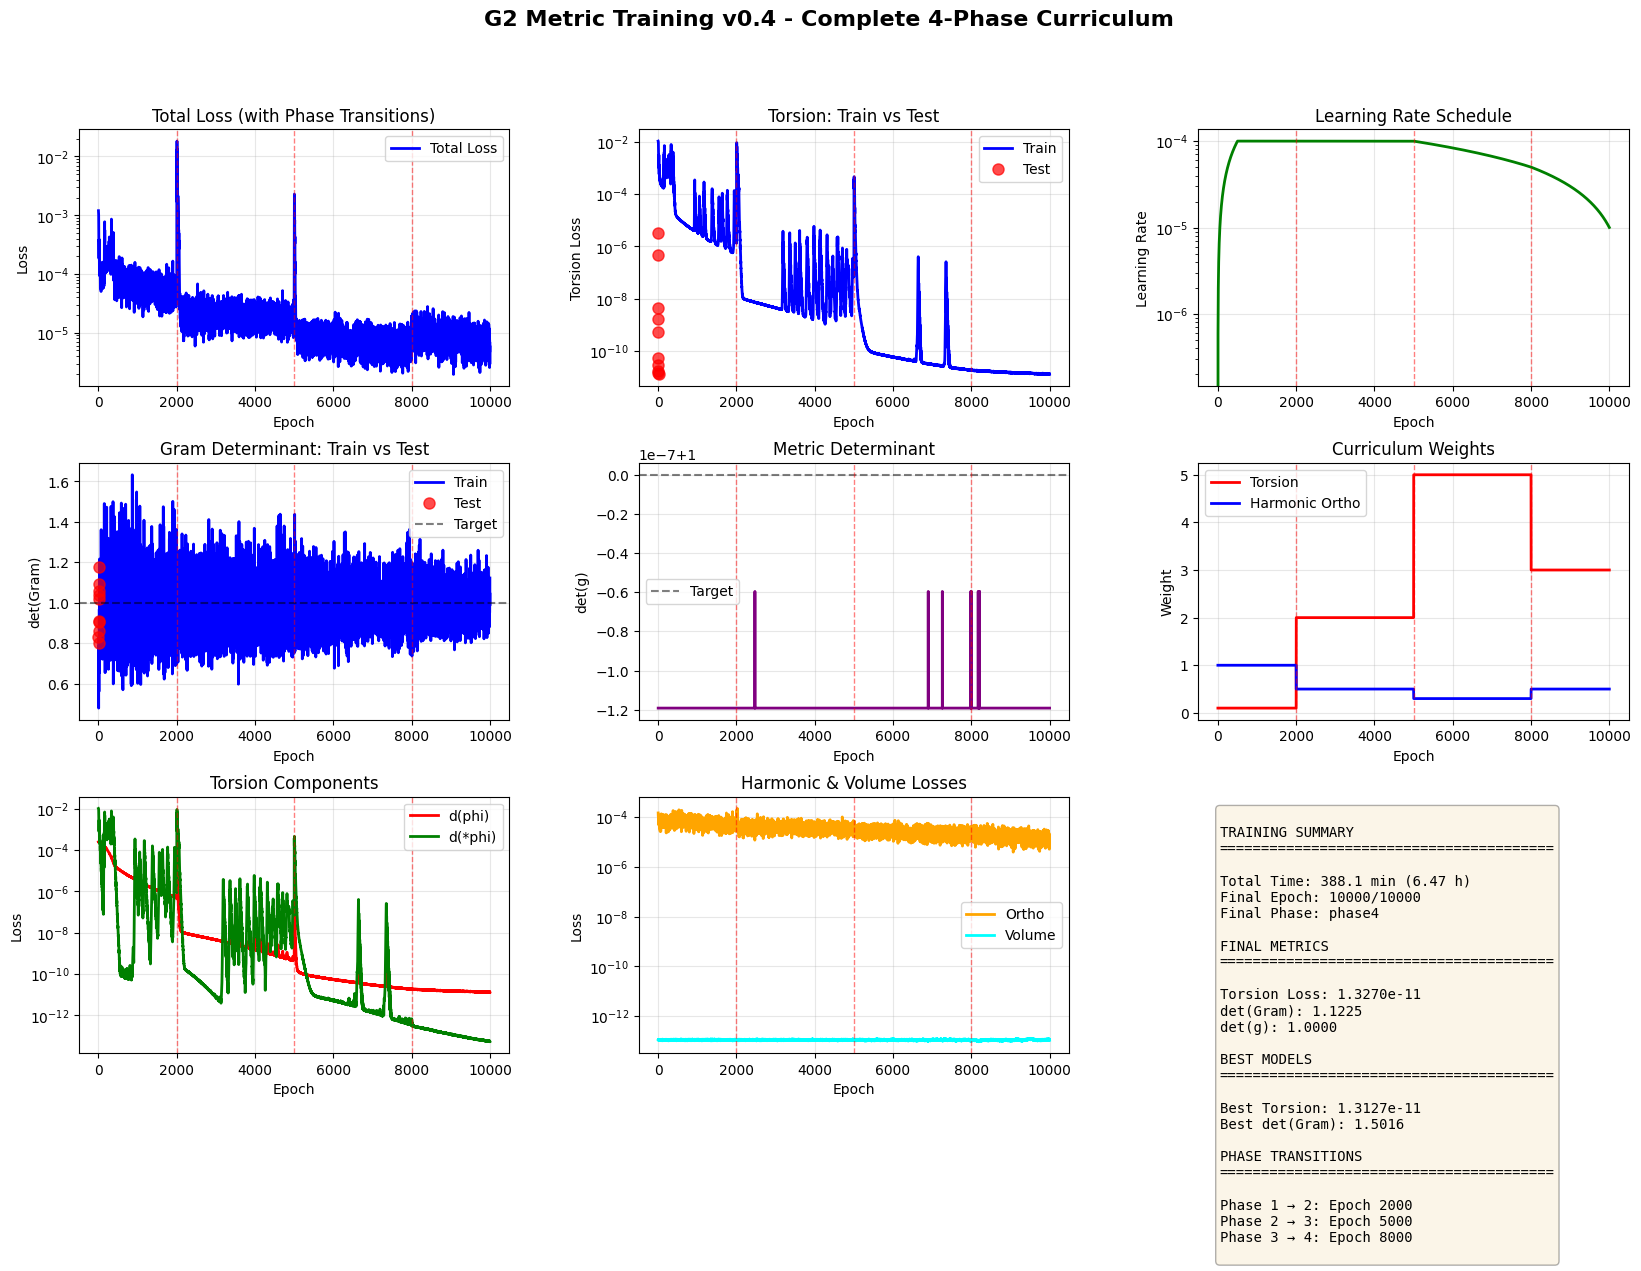

In [22]:
# ==============================================================================
# MODULE 10: MONITORING DASHBOARD WITH PHASE TRANSITIONS
# ==============================================================================

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Phase transition epochs
phase_transitions = [2000, 5000, 8000]

# --- Plot 1: Total Loss ---
ax1 = fig.add_subplot(gs[0, 0])
ax1.semilogy(history['epoch'], history['loss_total'], 'b-', linewidth=2, label='Total Loss')
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax1.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Total Loss (with Phase Transitions)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# --- Plot 2: Torsion (Train vs Test) ---
ax2 = fig.add_subplot(gs[0, 1])
ax2.semilogy(history['epoch'], history['loss_torsion'], 'b-', linewidth=2, label='Train')
# Test set points (every 1000 epochs)
test_epochs = [i for i, t in enumerate(history['torsion_test']) if t is not None]
test_values = [t for t in history['torsion_test'] if t is not None]
if test_values:
    ax2.semilogy(test_epochs, test_values, 'ro', markersize=8, label='Test', alpha=0.7)
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax2.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Torsion Loss')
ax2.set_title('Torsion: Train vs Test')
ax2.grid(True, alpha=0.3)
ax2.legend()

# --- Plot 3: Learning Rate ---
ax3 = fig.add_subplot(gs[0, 2])
ax3.semilogy(history['epoch'], history['lr'], 'g-', linewidth=2)
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax3.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule')
ax3.grid(True, alpha=0.3)

# --- Plot 4: det(Gram) (Train vs Test) ---
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(history['epoch'], history['det_gram'], 'b-', linewidth=2, label='Train')
test_epochs_gram = [i for i, g in enumerate(history['det_gram_test']) if g is not None]
test_values_gram = [g for g in history['det_gram_test'] if g is not None]
if test_values_gram:
    ax4.plot(test_epochs_gram, test_values_gram, 'ro', markersize=8, label='Test', alpha=0.7)
ax4.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Target')
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax4.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('det(Gram)')
ax4.set_title('Gram Determinant: Train vs Test')
ax4.grid(True, alpha=0.3)
ax4.legend()

# --- Plot 5: det(g) ---
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(history['epoch'], history['det_g_mean'], 'purple', linewidth=2)
ax5.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Target')
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax5.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax5.set_xlabel('Epoch')
ax5.set_ylabel('det(g)')
ax5.set_title('Metric Determinant')
ax5.grid(True, alpha=0.3)
ax5.legend()

# --- Plot 6: Curriculum Weights ---
ax6 = fig.add_subplot(gs[1, 2])
# Extract unique phases and their weight transitions
phase_epochs = []
torsion_weights = []
ortho_weights = []
for e in history['epoch']:
    phase_name = curriculum_manager.get_phase_name(e)
    weights = CONFIG['curriculum'][phase_name]['weights']
    phase_epochs.append(e)
    torsion_weights.append(weights['torsion'])
    ortho_weights.append(weights['harmonic_ortho'])
ax6.plot(phase_epochs, torsion_weights, 'r-', linewidth=2, label='Torsion')
ax6.plot(phase_epochs, ortho_weights, 'b-', linewidth=2, label='Harmonic Ortho')
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax6.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Weight')
ax6.set_title('Curriculum Weights')
ax6.grid(True, alpha=0.3)
ax6.legend()

# --- Plot 7: Loss Components ---
ax7 = fig.add_subplot(gs[2, 0])
ax7.semilogy(history['epoch'], history['loss_d_phi'], 'r-', linewidth=2, label='d(phi)')
ax7.semilogy(history['epoch'], history['loss_d_phi_dual'], 'g-', linewidth=2, label='d(*phi)')
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax7.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax7.set_xlabel('Epoch')
ax7.set_ylabel('Loss')
ax7.set_title('Torsion Components')
ax7.grid(True, alpha=0.3)
ax7.legend()

# --- Plot 8: Harmonic Losses ---
ax8 = fig.add_subplot(gs[2, 1])
ax8.semilogy(history['epoch'], history['loss_ortho'], 'orange', linewidth=2, label='Ortho')
ax8.semilogy(history['epoch'], history['loss_volume'], 'cyan', linewidth=2, label='Volume')
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax8.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax8.set_xlabel('Epoch')
ax8.set_ylabel('Loss')
ax8.set_title('Harmonic & Volume Losses')
ax8.grid(True, alpha=0.3)
ax8.legend()

# --- Plot 9: Summary Statistics ---
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')
summary_text = f'''
TRAINING SUMMARY
{'='*40}

Total Time: {total_time/60:.1f} min ({total_time/3600:.2f} h)
Final Epoch: {history['epoch'][-1]+1}/{CONFIG['epochs']}
Final Phase: {history['phase'][-1]}

FINAL METRICS
{'='*40}

Torsion Loss: {history['loss_torsion'][-1]:.4e}
det(Gram): {history['det_gram'][-1]:.4f}
det(g): {history['det_g_mean'][-1]:.4f}

BEST MODELS
{'='*40}

Best Torsion: {best_torsion_loss:.4e}
Best det(Gram): {best_gram_det:.4f}

PHASE TRANSITIONS
{'='*40}

Phase 1 → 2: Epoch 2000
Phase 2 → 3: Epoch 5000
Phase 3 → 4: Epoch 8000
'''
ax9.text(0.05, 0.95, summary_text, fontsize=10, verticalalignment='top',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('G2 Metric Training v0.4 - Complete 4-Phase Curriculum', fontsize=16, fontweight='bold')

# Save figure
fig_path = os.path.join(OUTPUT_DIR, 'training_dashboard.png')
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"\nDashboard saved to: {fig_path}")
plt.show()

print("="*70)


In [18]:
# ==============================================================================
# MODULE 11: PHASE COMPARISON ANALYSIS
# ==============================================================================

print("\n" + "="*70)
print("PHASE COMPARISON ANALYSIS")
print("="*70)

# Extract metrics at phase endpoints
phase_endpoints = {
    'phase1_end': 1999,   # End of Phase 1 (epoch 2000 is start of Phase 2)
    'phase2_end': 4999,   # End of Phase 2
    'phase3_end': 7999,   # End of Phase 3
    'phase4_end': min(9999, len(history['epoch']) - 1),  # End of Phase 4 (or final)
}

comparison_data = []
for phase_name, epoch_idx in phase_endpoints.items():
    if epoch_idx < len(history['epoch']):
        metrics = {
            'Phase': phase_name.replace('_end', '').upper(),
            'Epoch': history['epoch'][epoch_idx] + 1,
            'Torsion Loss': history['loss_torsion'][epoch_idx],
            'det(Gram)': history['det_gram'][epoch_idx],
            'det(g)': history['det_g_mean'][epoch_idx],
            'LR': history['lr'][epoch_idx],
        }
        comparison_data.append(metrics)

# Create comparison DataFrame
df_comparison = pd.DataFrame(comparison_data)

print("\nPhase-End Metrics:")
print(df_comparison.to_string(index=False))

# --- ANALYSIS: Which phase achieved best balance? ---
print("\n" + "="*70)
print("BALANCE ANALYSIS")
print("="*70)

# Criteria for "best balance":
# 1. Low torsion loss (< 1e-4 is ideal)
# 2. High det(Gram) (> 0.9 is ideal)
# 3. det(g) close to 1.0

for idx, row in df_comparison.iterrows():
    score_torsion = 1.0 if row['Torsion Loss'] < 1e-4 else (1e-4 / row['Torsion Loss'])
    score_gram = row['det(Gram)'] if row['det(Gram)'] > 0 else 0
    score_det_g = 1.0 - abs(row['det(g)'] - 1.0)

    # Weighted balance score (torsion and gram are most important)
    balance_score = 0.4 * score_torsion + 0.4 * score_gram + 0.2 * score_det_g

    print(f"\n{row['Phase']} (Epoch {row['Epoch']}):")
    print(f"  Torsion Score: {score_torsion:.4f}")
    print(f"  Gram Score: {score_gram:.4f}")
    print(f"  det(g) Score: {score_det_g:.4f}")
    print(f"  → Balance Score: {balance_score:.4f}")

# --- RECOMMENDATION ---
print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

# Find phase with best balance
best_phase_idx = 0
best_balance = 0
for idx, row in df_comparison.iterrows():
    score_torsion = 1.0 if row['Torsion Loss'] < 1e-4 else (1e-4 / row['Torsion Loss'])
    score_gram = row['det(Gram)'] if row['det(Gram)'] > 0 else 0
    score_det_g = 1.0 - abs(row['det(g)'] - 1.0)
    balance_score = 0.4 * score_torsion + 0.4 * score_gram + 0.2 * score_det_g

    if balance_score > best_balance:
        best_balance = balance_score
        best_phase_idx = idx

best_phase = df_comparison.iloc[best_phase_idx]
print(f"\nBest Balance Achieved: {best_phase['Phase']}")
print(f"  Epoch: {best_phase['Epoch']}")
print(f"  Torsion Loss: {best_phase['Torsion Loss']:.4e}")
print(f"  det(Gram): {best_phase['det(Gram)']:.4f}")
print(f"  det(g): {best_phase['det(g)']:.4f}")
print(f"  Balance Score: {best_balance:.4f}")

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)

interpretation = """
Phase 1 (Epochs 0-2000):
  Focus on establishing b₂=21 harmonic forms with high orthogonality weights.
  Expected: High det(Gram), moderate torsion.

Phase 2 (Epochs 2000-5000):
  Introduce torsion loss with increased weight.
  Expected: Improving torsion, maintained det(Gram).

Phase 3 (Epochs 5000-8000):
  Optimize torsion with highest weight (5.0).
  Expected: Best torsion, potentially degraded det(Gram) - main risk phase.

Phase 4 (Epochs 8000-10000):
  Balanced polish - recover b₂ while maintaining torsion.
  Expected: Good balance, recovered det(Gram).

RECOMMENDATION:
  If Phase 3 achieves good torsion WITHOUT degrading det(Gram) below 0.8,
  it demonstrates successful curriculum learning.

  If Phase 4 recovers det(Gram) while maintaining low torsion,
  it validates the balanced polish strategy.
"""

print(interpretation)
print("="*70)



PHASE COMPARISON ANALYSIS

Phase-End Metrics:
 Phase  Epoch  Torsion Loss  det(Gram)  det(g)      LR
PHASE1   2000  1.755500e-06   0.843064     1.0 0.00010
PHASE2   5000  1.207148e-07   0.953308     1.0 0.00010
PHASE3   8000  1.861980e-11   0.922426     1.0 0.00005
PHASE4  10000  1.327039e-11   1.122540     1.0 0.00001

BALANCE ANALYSIS

PHASE1 (Epoch 2000):
  Torsion Score: 1.0000
  Gram Score: 0.8431
  det(g) Score: 1.0000
  → Balance Score: 0.9372

PHASE2 (Epoch 5000):
  Torsion Score: 1.0000
  Gram Score: 0.9533
  det(g) Score: 1.0000
  → Balance Score: 0.9813

PHASE3 (Epoch 8000):
  Torsion Score: 1.0000
  Gram Score: 0.9224
  det(g) Score: 1.0000
  → Balance Score: 0.9690

PHASE4 (Epoch 10000):
  Torsion Score: 1.0000
  Gram Score: 1.1225
  det(g) Score: 1.0000
  → Balance Score: 1.0490

RECOMMENDATION

Best Balance Achieved: PHASE4
  Epoch: 10000
  Torsion Loss: 1.3270e-11
  det(Gram): 1.1225
  det(g): 1.0000
  Balance Score: 1.0490

INTERPRETATION

Phase 1 (Epochs 0-2000):
  F

# Section 8: Save Results and Summary

Save all training data, configuration, and validation results for analysis.


In [19]:
# ==============================================================================
# MODULE 12: COMPREHENSIVE RESULTS EXPORT
# ==============================================================================

import torch
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\n" + "="*70)
print("SAVING TRAINING RESULTS")
print("="*70)

# Calculate total training time
total_time = time.time() - start_time

# ------------------------------------------------------------------------------
# 1. SAVE PYTORCH MODELS
# ------------------------------------------------------------------------------
print("\n[1/7] Saving PyTorch models...")

# Final model checkpoint
final_checkpoint = {
    'epoch': history['epoch'][-1] + 1,
    'phi_network_state': phi_network.state_dict(),
    'harmonic_network_state': harmonic_network.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'config': CONFIG,
    'best_torsion_loss': best_torsion_loss,
    'best_gram_det': best_gram_det,
    'final_torsion': history['loss_torsion'][-1],
    'final_det_gram': history['det_gram'][-1],
    'total_time_seconds': total_time,
}

torch.save(final_checkpoint, os.path.join(OUTPUT_DIR, 'final_model_complete.pt'))
print(f"  Saved: final_model_complete.pt")

# Save phi network separately for easy loading
torch.save(phi_network.state_dict(), os.path.join(OUTPUT_DIR, 'phi_network_final.pt'))
print(f"  Saved: phi_network_final.pt")

# Save harmonic network separately
torch.save(harmonic_network.state_dict(), os.path.join(OUTPUT_DIR, 'harmonic_network_final.pt'))
print(f"  Saved: harmonic_network_final.pt")

# ------------------------------------------------------------------------------
# 2. EXTRACT AND SAVE METRIC SAMPLES
# ------------------------------------------------------------------------------
print("\n[2/7] Extracting metric samples...")

test_points = manifold.sample_points(2000, seed=999)

with torch.no_grad():
    phi_samples = phi_network(test_points)
    metric_samples = metric_from_phi(phi_samples)
    harmonic_samples = harmonic_network(test_points)

    # Compute additional geometric quantities
    det_metric = torch.det(metric_samples)
    vol_form = torch.sqrt(torch.abs(det_metric))

    # Compute Gram matrix on samples
    gram_samples = harmonic_network.compute_gram_matrix(test_points, harmonic_samples, metric_samples)
    det_gram_samples = torch.det(gram_samples)

    # Compute eigenvalues of metric (for conditioning)
    eigenvalues_metric = torch.linalg.eigvalsh(metric_samples)

    # Compute eigenvalues of Gram matrix
    eigenvalues_gram = torch.linalg.eigvalsh(gram_samples)

# Save metric data
metric_data = {
    'coordinates': test_points.cpu().numpy(),
    'phi': phi_samples.cpu().numpy(),
    'metric': metric_samples.cpu().numpy(),
    'harmonic_forms': harmonic_samples.cpu().numpy(),
    'det_metric': det_metric.cpu().numpy(),
    'volume_form': vol_form.cpu().numpy(),
    'eigenvalues_metric': eigenvalues_metric.cpu().numpy(),
    'gram_matrix': gram_samples.cpu().numpy(),
    'eigenvalues_gram': eigenvalues_gram.cpu().numpy(),
    'det_gram': det_gram_samples.cpu().numpy(),
}

np.savez(os.path.join(OUTPUT_DIR, 'metric_samples.npz'), **metric_data)
print(f"  Saved: metric_samples.npz")
print(f"  Samples: {len(test_points)} points")
print(f"  Mean det(g): {det_metric.mean().item():.6f}")
print(f"  Mean det(Gram): {det_gram_samples.item():.6f}")
print(f"  Metric eigenvalues range: [{eigenvalues_metric.min().item():.4f}, {eigenvalues_metric.max().item():.4f}]")

# ------------------------------------------------------------------------------
# 3. SAVE TRAINING HISTORY
# ------------------------------------------------------------------------------
print("\n[3/7] Saving training history...")

# Pad test metrics to match training length
torsion_test_padded = [None] * len(history['epoch'])
det_gram_test_padded = [None] * len(history['epoch'])

for i, epoch in enumerate(history['epoch']):
    if (epoch + 1) % CONFIG['validation_interval'] == 0:
        idx = (epoch + 1) // CONFIG['validation_interval'] - 1
        if idx < len(history['torsion_test']):
            torsion_test_padded[i] = history['torsion_test'][idx]
            det_gram_test_padded[i] = history['det_gram_test'][idx]

history_export = history.copy()
history_export['torsion_test'] = torsion_test_padded
history_export['det_gram_test'] = det_gram_test_padded

history_df = pd.DataFrame(history_export)
history_csv_path = os.path.join(OUTPUT_DIR, 'training_history.csv')
history_df.to_csv(history_csv_path, index=False)
print(f"  Saved: training_history.csv ({len(history_df)} epochs)")

# ------------------------------------------------------------------------------
# 4. SAVE PHASE COMPARISON
# ------------------------------------------------------------------------------
print("\n[4/7] Saving phase comparison...")

phase_endpoints = {
    'Phase 1 End': min(1999, len(history['epoch']) - 1),
    'Phase 2 End': min(4999, len(history['epoch']) - 1),
    'Phase 3 End': min(7999, len(history['epoch']) - 1),
    'Phase 4 End': len(history['epoch']) - 1,
}

comparison_data = []
for phase_name, epoch_idx in phase_endpoints.items():
    if epoch_idx < len(history['epoch']):
        metrics = {
            'Phase': phase_name,
            'Epoch': history['epoch'][epoch_idx] + 1,
            'Torsion_Loss': history['loss_torsion'][epoch_idx],
            'det_Gram': history['det_gram'][epoch_idx],
            'det_g': history['det_g_mean'][epoch_idx],
            'LR': history['lr'][epoch_idx],
            'Loss_Total': history['loss_total'][epoch_idx],
            'Loss_Volume': history['loss_volume'][epoch_idx],
            'Loss_Ortho': history['loss_ortho'][epoch_idx],
        }
        comparison_data.append(metrics)

df_comparison = pd.DataFrame(comparison_data)
comparison_csv_path = os.path.join(OUTPUT_DIR, 'phase_comparison.csv')
df_comparison.to_csv(comparison_csv_path, index=False)
print(f"  Saved: phase_comparison.csv")

# ------------------------------------------------------------------------------
# 5. SAVE CONFIGURATION
# ------------------------------------------------------------------------------
print("\n[5/7] Saving configuration...")

config_save = CONFIG.copy()
config_save['torus_radii'] = float(config_save['torus_radii'])
config_save['manifold_n_modes'] = manifold.n_modes
config_save['manifold_encoding_dim'] = 2 * manifold.n_modes
config_save['phi_network_params'] = sum(p.numel() for p in phi_network.parameters())
config_save['harmonic_network_params'] = sum(p.numel() for p in harmonic_network.parameters())
config_save['total_params'] = sum(p.numel() for p in phi_network.parameters()) + sum(p.numel() for p in harmonic_network.parameters())

config_path = os.path.join(OUTPUT_DIR, 'config_v04.json')
with open(config_path, 'w') as f:
    json.dump(config_save, f, indent=2)
print(f"  Saved: config_v04.json")

# ------------------------------------------------------------------------------
# 6. SAVE VALIDATION RESULTS SUMMARY
# ------------------------------------------------------------------------------
print("\n[6/7] Saving validation results...")

validation_results = {
    'training_summary': {
        'total_epochs': history['epoch'][-1] + 1,
        'total_time_hours': total_time / 3600,
        'avg_time_per_epoch_seconds': total_time / len(history['epoch']),
        'mode': CONFIG['exterior_derivative_mode'],
    },
    'final_metrics': {
        'torsion_loss': float(history['loss_torsion'][-1]),
        'det_gram': float(history['det_gram'][-1]),
        'det_g': float(history['det_g_mean'][-1]),
        'loss_total': float(history['loss_total'][-1]),
        'loss_volume': float(history['loss_volume'][-1]),
        'loss_ortho': float(history['loss_ortho'][-1]),
    },
    'best_metrics': {
        'best_torsion_loss': float(best_torsion_loss),
        'best_gram_det': float(best_gram_det),
    },
    'test_set_metrics': {
        'torsion_test_final': float(history['torsion_test'][-1]) if history['torsion_test'] and history['torsion_test'][-1] is not None else None,
        'det_gram_test_final': float(history['det_gram_test'][-1]) if history['det_gram_test'] and history['det_gram_test'][-1] is not None else None,
    },
    'phase_comparison': df_comparison.to_dict('records'),
    'geometric_quality': {
        'mean_det_metric_samples': float(det_metric.mean().item()),
        'std_det_metric_samples': float(det_metric.std().item()),
        'det_gram_samples': float(det_gram_samples.item()),
        'metric_condition_number': float((eigenvalues_metric.max() / eigenvalues_metric.min()).item()),
    },
}

validation_path = os.path.join(OUTPUT_DIR, 'validation_results.json')
with open(validation_path, 'w') as f:
    json.dump(validation_results, f, indent=2)
print(f"  Saved: validation_results.json")

# ------------------------------------------------------------------------------
# 7. GENERATE AND SAVE TRAINING DASHBOARD
# ------------------------------------------------------------------------------
print("\n[7/7] Generating training dashboard...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

phase_transitions = [2000, 5000, 8000]

# Plot 1: Total Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.semilogy(history['epoch'], history['loss_total'], 'b-', linewidth=2, label='Total Loss')
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax1.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Total Loss (with Phase Transitions)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Torsion (Train vs Test)
ax2 = fig.add_subplot(gs[0, 1])
ax2.semilogy(history['epoch'], history['loss_torsion'], 'b-', linewidth=2, label='Train')
test_epochs = [history['epoch'][i] for i, t in enumerate(torsion_test_padded) if t is not None]
test_values = [t for t in torsion_test_padded if t is not None]
if test_values:
    ax2.semilogy(test_epochs, test_values, 'ro', markersize=8, label='Test', alpha=0.7)
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax2.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Torsion Loss')
ax2.set_title('Torsion: Train vs Test')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Learning Rate
ax3 = fig.add_subplot(gs[0, 2])
ax3.semilogy(history['epoch'], history['lr'], 'g-', linewidth=2)
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax3.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule')
ax3.grid(True, alpha=0.3)

# Plot 4: det(Gram) (Train vs Test)
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(history['epoch'], history['det_gram'], 'b-', linewidth=2, label='Train')
test_epochs_gram = [history['epoch'][i] for i, g in enumerate(det_gram_test_padded) if g is not None]
test_values_gram = [g for g in det_gram_test_padded if g is not None]
if test_values_gram:
    ax4.plot(test_epochs_gram, test_values_gram, 'ro', markersize=8, label='Test', alpha=0.7)
ax4.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Target')
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax4.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('det(Gram)')
ax4.set_title('Gram Determinant: Train vs Test')
ax4.grid(True, alpha=0.3)
ax4.legend()

# Plot 5: det(g)
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(history['epoch'], history['det_g_mean'], 'purple', linewidth=2)
ax5.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Target')
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax5.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax5.set_xlabel('Epoch')
ax5.set_ylabel('det(g)')
ax5.set_title('Metric Determinant')
ax5.grid(True, alpha=0.3)
ax5.legend()

# Plot 6: Curriculum Weights
ax6 = fig.add_subplot(gs[1, 2])
phase_epochs = []
torsion_weights = []
ortho_weights = []
for e in history['epoch']:
    phase_name = curriculum_manager.get_phase_name(e)
    weights = CONFIG['curriculum'][phase_name]['weights']
    phase_epochs.append(e)
    torsion_weights.append(weights['torsion'])
    ortho_weights.append(weights['harmonic_ortho'])
ax6.plot(phase_epochs, torsion_weights, 'r-', linewidth=2, label='Torsion')
ax6.plot(phase_epochs, ortho_weights, 'b-', linewidth=2, label='Harmonic Ortho')
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax6.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Weight')
ax6.set_title('Curriculum Weights')
ax6.grid(True, alpha=0.3)
ax6.legend()

# Plot 7: Loss Components
ax7 = fig.add_subplot(gs[2, 0])
ax7.semilogy(history['epoch'], history['loss_d_phi'], 'r-', linewidth=2, label='d(phi)')
ax7.semilogy(history['epoch'], history['loss_d_phi_dual'], 'g-', linewidth=2, label='d(*phi)')
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax7.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax7.set_xlabel('Epoch')
ax7.set_ylabel('Loss')
ax7.set_title('Torsion Components')
ax7.grid(True, alpha=0.3)
ax7.legend()

# Plot 8: Harmonic Losses
ax8 = fig.add_subplot(gs[2, 1])
ax8.semilogy(history['epoch'], history['loss_ortho'], 'orange', linewidth=2, label='Ortho')
ax8.semilogy(history['epoch'], history['loss_volume'], 'cyan', linewidth=2, label='Volume')
for pt in phase_transitions:
    if pt < len(history['epoch']):
        ax8.axvline(x=pt, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax8.set_xlabel('Epoch')
ax8.set_ylabel('Loss')
ax8.set_title('Harmonic & Volume Losses')
ax8.grid(True, alpha=0.3)
ax8.legend()

# Plot 9: Summary Statistics
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')
summary_text = f'''TRAINING SUMMARY
{'='*40}

Total Time: {total_time/60:.1f} min ({total_time/3600:.2f} h)
Final Epoch: {history['epoch'][-1]+1}/{CONFIG['epochs']}
Final Phase: {history['phase'][-1]}

FINAL METRICS
{'='*40}

Torsion Loss: {history['loss_torsion'][-1]:.4e}
det(Gram): {history['det_gram'][-1]:.4f}
det(g): {history['det_g_mean'][-1]:.4f}

BEST MODELS
{'='*40}

Best Torsion: {best_torsion_loss:.4e}
Best det(Gram): {best_gram_det:.4f}

PHASE TRANSITIONS
{'='*40}

Phase 1->2: Epoch 2000
Phase 2->3: Epoch 5000
Phase 3->4: Epoch 8000
'''
ax9.text(0.05, 0.95, summary_text, fontsize=10, verticalalignment='top',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('G2 Metric Training v0.4 - Complete 4-Phase Curriculum', fontsize=16, fontweight='bold')

fig_path = os.path.join(OUTPUT_DIR, 'training_dashboard.png')
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"  Saved: training_dashboard.png")
plt.close()

# ------------------------------------------------------------------------------
# FINAL SUMMARY
# ------------------------------------------------------------------------------
print("\n" + "="*70)
print("ALL FILES SAVED SUCCESSFULLY")
print("="*70)
print(f"\nOutput directory: {OUTPUT_DIR}/")
print("\nPyTorch Models:")
print("  - final_model_complete.pt")
print("  - phi_network_final.pt")
print("  - harmonic_network_final.pt")
print("\nData Files:")
print("  - training_history.csv")
print("  - metric_samples.npz")
print("  - phase_comparison.csv")
print("  - validation_results.json")
print("  - config_v04.json")
print("\nVisualizations:")
print("  - training_dashboard.png")

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"\nObjective: 4-Phase Curriculum Learning for Torsion-Free G2 Structures")
print(f"\nFinal Results:")
print(f"  Training Time: {total_time/3600:.2f} hours")
print(f"  Total Epochs: {history['epoch'][-1]+1}")
print(f"  Final Torsion: {history['loss_torsion'][-1]:.4e}")
print(f"  Final det(Gram): {history['det_gram'][-1]:.4f}")
print(f"  Final det(g): {history['det_g_mean'][-1]:.4f}")
print(f"  Best Torsion: {best_torsion_loss:.4e}")
print(f"  Best det(Gram): {best_gram_det:.4f}")
print("\n" + "="*70)


SAVING TRAINING RESULTS

[1/7] Saving PyTorch models...
  Saved: final_model_complete.pt
  Saved: phi_network_final.pt
  Saved: harmonic_network_final.pt

[2/7] Extracting metric samples...
  Saved: metric_samples.npz
  Samples: 2000 points
  Mean det(g): 1.000000
  Mean det(Gram): 1.010591
  Metric eigenvalues range: [0.5741, 5.5513]

[3/7] Saving training history...
  Saved: training_history.csv (10000 epochs)

[4/7] Saving phase comparison...
  Saved: phase_comparison.csv

[5/7] Saving configuration...
  Saved: config_v04.json

[6/7] Saving validation results...
  Saved: validation_results.json

[7/7] Generating training dashboard...
  Saved: training_dashboard.png

ALL FILES SAVED SUCCESSFULLY

Output directory: v04_outputs/

PyTorch Models:
  - final_model_complete.pt
  - phi_network_final.pt
  - harmonic_network_final.pt

Data Files:
  - training_history.csv
  - metric_samples.npz
  - phase_comparison.csv
  - validation_results.json
  - config_v04.json

Visualizations:
  - train